# Generate Warehouse map

In [15]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define the colormap
cmap = ListedColormap(["white", "black", "yellow", "red"])

In [53]:
ROWS = 5
COLS = 5

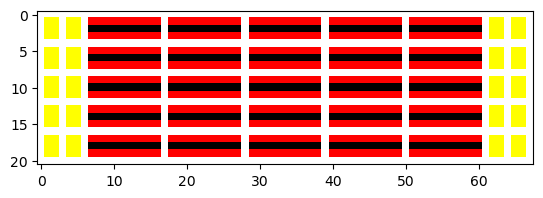

In [60]:
people = np.array(
    [[2,2,0,2,2],
     [2,2,0,2,2],
     [2,2,0,2,2],
    ]
)

shelves = np.array(
    [[3]*10,
     [1]*10,
     [3]*10,
    ]
)

hall_ver = np.array(
    [[0],
     [0],
     [0],
    ]
)

plt.imshow(np.concatenate((people, hall_ver, shelves, hall_ver, people), axis=1), cmap=cmap, vmin=0, vmax=3)


row = people

for j in range(COLS):
    row = np.concatenate((row, hall_ver, shelves), axis=1)

row = np.concatenate((row, hall_ver, people), axis=1)

plt.imshow(row, cmap=cmap, vmin=0, vmax=3)


hall_hor = np.array(
    [[0]*len(row[0])]
)

warehouse = row

for i in range(ROWS-1):
    warehouse = np.concatenate((warehouse, hall_hor, row), axis=0)

# pad the warehouse with a row of zeros
warehouse = np.pad(warehouse, 1, 'constant')

plt.imshow(warehouse, cmap=cmap, vmin=0, vmax=3)

# Softmax

In [20]:
import torch
import torch.nn.functional as F

import numpy as np

In [25]:
F.softmax(torch.tensor([[-0.039,  0.135],
[-0.215,  0.362],
[ 0.577, -0.623],
[-0.323,  0.443],
[ 0.473, -0.558],
[ 0.588, -0.609],
[-0.031, -0.095],
[-0.049, -0.074],
[-0.013, -0.093]]), dim=1)*100

tensor([[45.6609, 54.3391],
        [35.9623, 64.0377],
        [76.8525, 23.1475],
        [31.7345, 68.2655],
        [73.7110, 26.2890],
        [76.7991, 23.2009],
        [51.5995, 48.4005],
        [50.6250, 49.3750],
        [51.9989, 48.0011]])

In [24]:
F.softmax(torch.tensor([[-0.086,  0.217],
[-0.205,  0.378],
[ 0.57, -0.59],
[-0.251,  0.4],
[ 0.527, -0.564],
[ 0.609, -0.601],
[ 0.046, -0.136],
[ 0.012, -0.096],
[ 0.038, -0.103]]), dim=1)*100

tensor([[42.4824, 57.5176],
        [35.8243, 64.1757],
        [76.1333, 23.8667],
        [34.2764, 65.7236],
        [74.8570, 25.1430],
        [77.0299, 22.9701],
        [54.5375, 45.4625],
        [52.6974, 47.3026],
        [53.5192, 46.4808]])

In [13]:
starts = [(1,2),(2,3),(3,4)]
goals = [[(3,3),(4,4),(5,5)]]

x = {}

In [15]:
x[tuple(starts)] = {}

In [16]:
x[tuple(starts)][tuple([tuple(x) for x in goals])] = 0

In [17]:
x[tuple(starts)][tuple([tuple(x) for x in goals])]

0

# CONFIG FILE

In [6]:
import yaml

# Load the YAML config file
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Access values
BATCH_SIZE = config["training"]
BATCH_SIZE

{'BATCH_SIZE': 32,
 'LAMBDA': 1,
 'LR': '1e-4',
 'BUFFER_SIZE': 10000,
 'TRAIN_STEPS': '1e10',
 'N_ACTIONS': 2}

# FOV

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
num_agents = 3
obs_radius = 7

obs = np.zeros((num_agents, 6, 2*obs_radius+1, 2*obs_radius+1), dtype=bool)

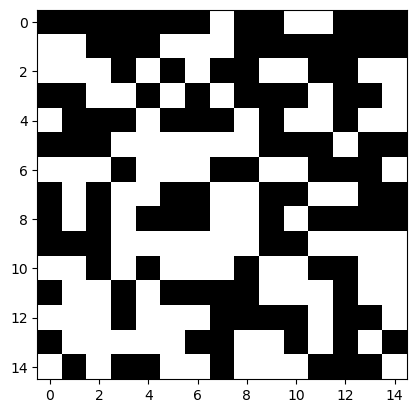

In [50]:
map_size = (15, 15)
grid_map = np.random.randint(2, size=map_size)
plt.imshow(grid_map, cmap='gray_r')

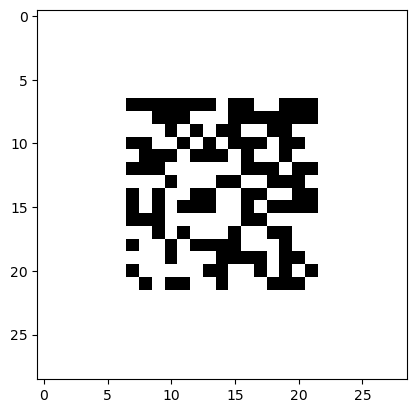

In [51]:
obstacle_map = np.pad(grid_map, obs_radius, 'constant', constant_values=0)
plt.imshow(obstacle_map, cmap='gray_r')

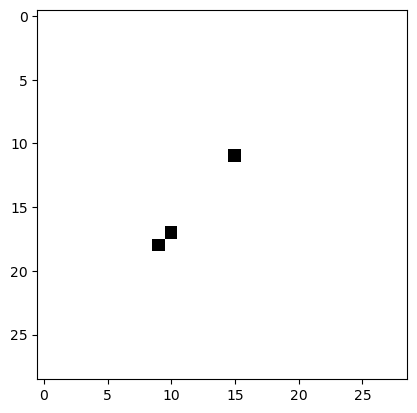

In [52]:
agents_pos = np.random.randint(1, map_size[0]-1, size=(num_agents, 2))
agent_map = np.zeros((map_size), dtype=bool)
agent_map[agents_pos[:,0], agents_pos[:,1]] = 1
agent_map = np.pad(agent_map, obs_radius, 'constant', constant_values=0)
plt.imshow(agent_map, cmap='gray_r')

In [53]:
# 1. neighboring agents
# 2. obstacle_map
# 3. heuri_map

for i, agent_pos in enumerate(agents_pos):
    x, y = agent_pos
    obs[i, 0] = agent_map[x:x+2*obs_radius+1, y:y+2*obs_radius+1]
    obs[i, 0, obs_radius, obs_radius] = 0
    obs[i, 1] = obstacle_map[x:x+2*obs_radius+1, y:y+2*obs_radius+1]
    # obs[i, 2:] = heuri_map[i, :, x:x+2*obs_radius+1, y:y+2*obs_radius+1]

In [54]:
agents_pos[0]

array([4, 8])

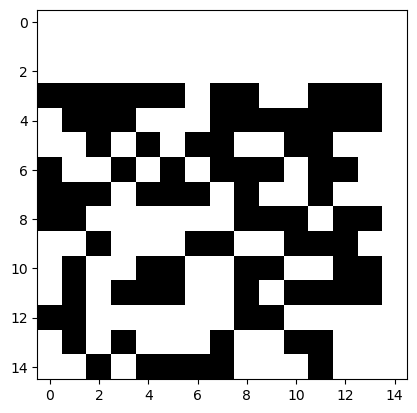

In [57]:
plt.imshow(obs[0,1], cmap='gray_r')